In [1]:
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import time
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 45})

In [2]:
def load_dataframe_from_files(dirin, fileprefix, max_files=100):
    import glob
    files = glob.glob(os.path.join(dirin, fileprefix))
    print("[Info] Loading {} files wt prefix:\n{}".format(len(files), fileprefix))
    df = pd.read_csv(files[0], comment='#', index_col=False)
    df["filenumber"] = 0
    for i, file in enumerate(files[1:max_files]):
        print(".", end='')
        dftmp = pd.read_csv(file, comment='#', index_col=False)
        dftmp["filenumber"] = i+1
        df = pd.concat([df, dftmp])
    print("")
    return df

In [3]:
n_inner_slices, n_outer_slices = 12, 20

In [4]:
# Load Ar39
init = time.time()

dirin = os.path.join("..", "..", "Data", "CriticalMuEvents", "Coincidence15Ge_18122020", "Snapshot")
fileprefix = "Snapshot*csv"
dfmu = load_dataframe_from_files(dirin, fileprefix, 100)

print("[Info] Loaded {} Muons in {:.2f} seconds".format(len(dfmu.groupby(["filenumber", "eventnumber"]).count()), time.time() - init))
dfmu.head()

[Info] Loading 100 files wt prefix:
Snapshot*csv
...................................................................................................
[Info] Loaded 9086 Muons in 0.88 seconds


,eventnumber,energydeposition,pedetected,InnerSlice0,InnerSlice1,InnerSlice2,InnerSlice3,InnerSlice4,InnerSlice5,InnerSlice6,...,OuterSlice12,OuterSlice13,OuterSlice14,OuterSlice15,OuterSlice16,OuterSlice17,OuterSlice18,OuterSlice19,Unnamed: 35,filenumber
0,1,341065.0,4544,105,181,315,386,351,289,153,...,24,16,9,14,3,17,19,36,NaN,0
1,2,292589.0,2213,0,1,5,23,45,65,50,...,294,110,46,17,6,2,2,1,NaN,0
2,3,1580670.0,6082,1,1,2,7,43,79,49,...,125,60,25,15,8,5,3,3,NaN,0
3,4,358867.0,2295,3,9,35,69,6,0,2,...,2,11,2,3,3,3,8,10,NaN,0
4,5,353831.0,1400,0,0,0,0,0,0,5,...,133,212,256,251,155,93,56,23,NaN,0


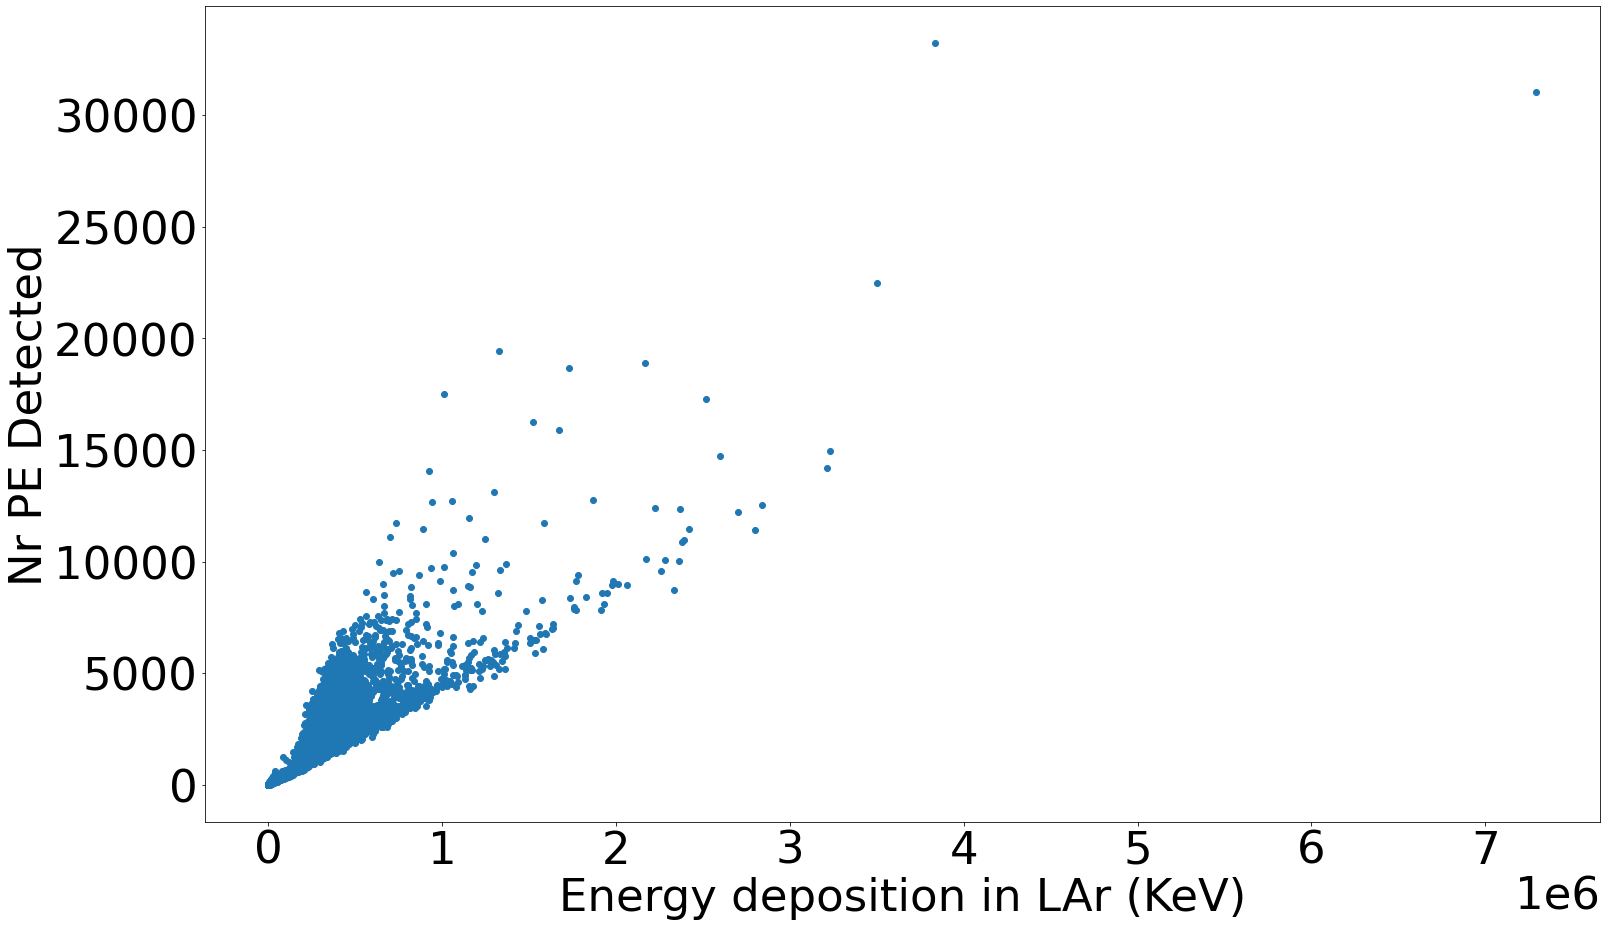

In [5]:
plt.scatter(dfmu.energydeposition, dfmu.pedetected)
plt.xlabel("Energy deposition in LAr (KeV)")
plt.ylabel("Nr PE Detected")
plt.show()

# compute features

In [6]:
# Create Features
def pe_detected(row):
    return np.sum(row.to_numpy())

def nr_active_slices(row):
    return np.nonzero(row.to_numpy())[0].shape[0]

def mean_npe(row):
    return np.mean(row.to_numpy())

def mean_npe_active(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return np.mean(rownp[rownonzero]) if rownonzero.shape[0]>0 else -1

def std_npe(row):
    return np.std(row.to_numpy())

def std_npe_active(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return np.std(rownp[rownonzero]) if rownonzero.shape[0]>0 else -1

def range_detections(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return rownonzero[-1] - rownonzero[0] + 1 if rownonzero.shape[0]>0 else -1

def spatial_var(row):
    rownp = row.to_numpy()
    ids = np.repeat(np.argwhere(rownp>0), rownp[rownp>0])
    return np.var(ids) if ids.shape[0]>0 else -1

def spatial_std(row):
    rownp = row.to_numpy()
    ids = np.repeat(np.argwhere(rownp>0), rownp[rownp>0])
    return np.std(ids) if ids.shape[0]>0 else -1

In [13]:
columns = ["eventnumber"] + [f"InnerSlice{i}" for i in range(12)] + [f"OuterSlice{i}" for i in range(20)]
snapshots = dfmu[columns].copy()
snapshots.head()

,eventnumber,InnerSlice0,InnerSlice1,InnerSlice2,InnerSlice3,InnerSlice4,InnerSlice5,InnerSlice6,InnerSlice7,InnerSlice8,...,OuterSlice10,OuterSlice11,OuterSlice12,OuterSlice13,OuterSlice14,OuterSlice15,OuterSlice16,OuterSlice17,OuterSlice18,OuterSlice19
0,1,105,181,315,386,351,289,153,112,94,...,99,53,24,16,9,14,3,17,19,36
1,2,0,1,5,23,45,65,50,54,16,...,120,322,294,110,46,17,6,2,2,1
2,3,1,1,2,7,43,79,49,9,8,...,800,355,125,60,25,15,8,5,3,3
3,4,3,9,35,69,6,0,2,1,3,...,11,3,2,11,2,3,3,3,8,10
4,5,0,0,0,0,0,0,5,12,21,...,32,88,133,212,256,251,155,93,56,23


In [14]:
# features for rforest
my_features = ["PEDetected_outer", "NActiveSlices_outer", "MeanNPEActive_outer", "SpatialVar_outer", "SpatialRange_outer", 
               "PEDetected_inner", "NActiveSlices_inner", "MeanNPEActive_inner", "SpatialVar_inner", "SpatialRange_inner",
               "PEDetected_tot", "NActiveSlices_tot", "MeanNPEActive_tot"]

init = time.time()
featmu = snapshots
featmu["PEDetected_inner"] = snapshots.iloc[:, 1:1+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
featmu["NActiveSlices_inner"] = snapshots.iloc[:, 1:1+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
featmu["MeanNPEActive_inner"] = snapshots.iloc[:, 1:1+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
featmu["StdNPEActive_inner"] = snapshots.iloc[:, 1:1+n_inner_slices].apply(lambda row: std_npe_active(row), axis=1)
featmu["SpatialRange_inner"] = snapshots.iloc[:, 1:1+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
featmu["SpatialVar_inner"] = snapshots.iloc[:, 1:1+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
featmu["SpatialStd_inner"] = snapshots.iloc[:, 1:1+n_inner_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Mu Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
featmu["PEDetected_outer"] = snapshots.iloc[:, 1+n_inner_slices:1+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
featmu["NActiveSlices_outer"] = snapshots.iloc[:, 1+n_inner_slices:1+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
featmu["MeanNPEActive_outer"] = snapshots.iloc[:, 1+n_inner_slices:1+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
featmu["StdNPEActive_outer"] = snapshots.iloc[:, 1+n_inner_slices:1+n_inner_slices+n_outer_slices].apply(lambda row: std_npe_active(row), axis=1)
featmu["SpatialRange_outer"] = snapshots.iloc[:, 1+n_inner_slices:1+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
featmu["SpatialVar_outer"] = snapshots.iloc[:, 1+n_inner_slices:1+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
featmu["SpatialStd_outer"] = snapshots.iloc[:, 1+n_inner_slices:1+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Mu Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
featmu["PEDetected_tot"] = featmu["PEDetected_inner"] + featmu["PEDetected_outer"]
featmu["NActiveSlices_tot"] = featmu["NActiveSlices_inner"] + featmu["NActiveSlices_outer"]
featmu["MeanNPEActive_tot"] = featmu["PEDetected_tot"] / featmu["NActiveSlices_tot"]
featmu = featmu.fillna(-1)
print("Compute combined features: {:.3f} sec".format(time.time() - init))

Compute Mu Inner features: 2.091 sec
Compute Mu Outer features: 2.206 sec
Compute combined features: 0.004 sec


# load model

In [15]:
from joblib import load

init = time.time()
rf = load("/home/luigi/Development/ML4NP/ML4GeneralMuons/bonsai_dtrees/rf_10est_5depth.joblib")
print("[Info] Loaded model in {:.2f} seconds".format(time.time() - init))

[Info] Loaded model in 0.49 seconds


# predict

In [17]:
data = featmu
data["y"] = 1
X_rf, y_rf = data.loc[:, my_features], data.loc[:, "y"]
X_rf = np.array(X_rf)
y_rf = np.array(y_rf)

init = time.time()
data["y_rf_pred"] = rf.predict_proba(X_rf)[:, 1]
data["cut_4nas"] = np.where(data.NActiveSlices_outer>=4, 1, 0)
data["cut_60pe"] = np.where(data.PEDetected_tot>60, 1, 0)
print("[Info] RForest predict in {:.3f} seconds".format(time.time() - init))

[Info] RForest predict in 0.009 seconds


In [19]:
data["y_combo"] = np.where(((data.cut_60pe>.5) | ((data.cut_4nas>.5) & (data.y_rf_pred>.5))), 1, 0)

In [20]:
print("True Positive: {}".format(len(data[data.y_combo==1])))
print("False Negative: {}".format(len(data[data.y_combo==0])))

True Positive: 8715
False Negative: 371


## statistics considering only NPE in [0, 60]

In [38]:
data[(data.PEDetected_tot<=60)].y_combo.describe()

count    981.000000
mean       0.621814
std        0.485182
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: y_combo, dtype: float64

In [41]:
data[(data.PEDetected_tot<=60) & (data.y_combo==0)].PEDetected_tot.describe()

count    371.000000
mean       4.571429
std        4.101699
min        1.000000
25%        2.000000
50%        3.000000
75%        6.000000
max       27.000000
Name: PEDetected_tot, dtype: float64

In [46]:
data[(data.PEDetected_tot<=60) & (data.y_combo==0)].PEDetected_tot.describe()

count    371.000000
mean       4.571429
std        4.101699
min        1.000000
25%        2.000000
50%        3.000000
75%        6.000000
max       27.000000
Name: PEDetected_tot, dtype: float64

## conclusions:
1. The proposed approach results effective for tagging cosmogenics events with an **efficiency of ~96%**

1. Considering the very low-energy muons (*<60 PE*), we achieve an efficiency of **62\%**

1. Looking at the **misclassified events**, they are `371` with NPE within [0, 27] (**very low-energy deposition**)

## notes:
1. we are considering snapshots from LAr acquisitions. any event with no detections in LAr veto system is not considered, even if it presents a deposit in Germanium.

,eventnumber,energydeposition,pedetected,InnerSlice0,InnerSlice1,InnerSlice2,InnerSlice3,InnerSlice4,InnerSlice5,InnerSlice6,...,OuterSlice12,OuterSlice13,OuterSlice14,OuterSlice15,OuterSlice16,OuterSlice17,OuterSlice18,OuterSlice19,Unnamed: 35,filenumber
0,1,341065.0,4544,105,181,315,386,351,289,153,...,24,16,9,14,3,17,19,36,NaN,0
1,2,292589.0,2213,0,1,5,23,45,65,50,...,294,110,46,17,6,2,2,1,NaN,0
2,3,1580670.0,6082,1,1,2,7,43,79,49,...,125,60,25,15,8,5,3,3,NaN,0
3,4,358867.0,2295,3,9,35,69,6,0,2,...,2,11,2,3,3,3,8,10,NaN,0
4,5,353831.0,1400,0,0,0,0,0,0,5,...,133,212,256,251,155,93,56,23,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,81,914972.0,4103,2,0,2,6,10,58,69,...,349,129,45,18,12,7,3,1,NaN,99
81,82,272839.0,1749,0,0,0,2,1,7,15,...,456,260,110,71,16,10,5,2,NaN,99
82,83,158260.0,681,0,0,0,0,0,0,0,...,62,106,162,127,80,35,15,4,NaN,99
83,84,311857.0,3422,255,229,191,129,137,134,152,...,43,67,87,63,53,41,29,32,NaN,99
